## Численное решение задачи $N$ тел

### Постановка задачи.

\begin{align*}
\frac{dr_i}{dt} &= v_i,\\
\frac{d v_i}{dt} & = \sum_{j \ne i}^N G m_j \frac{r_j - r_i}{|r_j - r_i|^3}.
\end{align*}

Здесь $m_i$, $r_i$, $v_i$— масса, радиус-вектор и скорость $i$-го тела соответственно ($i$ изменяется от $1$ до $N$), $G$ — гравитационная постоянная. 

Массы тел, а также положения и скорости в начальный момент времени считаются известными.

Необходимо найти положения и скорости всех частиц в произвольный момент времени.

#### Метод численного решения. Алгоритм Верле.

\begin{align*}
x_{n+1} &= x_n + v_n \Delta t + \frac{1}{2} a_n (\Delta t),\\
v_{n+1} &= v_n + \frac{1}{2}(a_{n+1} + a_n) \Delta t.
\end{align*}

### П.1. Решение при помощи solve_ivp

In [1]:
%load_ext autoreload
%autoreload 2

from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from celluloid import Camera
from matplotlib import animation

In [2]:
G = 6.6743e-11
m = [1.989e+30, 0.330e+24,	4.87e+24,	5.97e+24,	0.642e+24,	1898e+24,	568e+24,	86.8e+24,	102e+24]
names = ['SUN',  'MERCURY', 	 'VENUS', 	 'EARTH', 	'MARS', 	 'JUPITER', 	 'SATURN', 	 'URANUS', 	 'NEPTUNE']
y0 = np.array([0,    0,  0, 0,
      57.9e+9, 0,	0, 48000,
      108.2e+9, 0, 0, 35000,	
      149.6e+9,	0, 0, 29765, 
      228.0e+9, 0, 0, 24130,	
      778.5e+9, 0, 0, 13070,	
      1432.0e+9, 0, 0, 9870,	
      2867.0e+9, 0, 0, 6810,	
      4515.0e+9, 0, 0, 5434])

In [3]:
def n_body_system(t, y):
    '''
    y[i] ~ x[i]
    y[i+1] ~ y[i]
    y[i+2] ~ v_x[i]
    y[i+3] ~ v_y[i]
    '''
    
    N = y.shape[0]

    equations = np.zeros(N)

    for i in range (0, N, 4):
        equations[i] = y[i+2]
        equations[i+1] = y[i+3]
        for j in range(0, N, 4):
            if (i == j): continue
            x_length = y[j] - y[i]
            y_length = y[j+1] - y[i+1]
            r2 = x_length**2 + y_length**2
            r = np.sqrt(r2)
            f = G * m[j // 4] / r2
            equations[i+2] += f * x_length / r
            equations[i+3] += f * y_length / r
        
    return equations

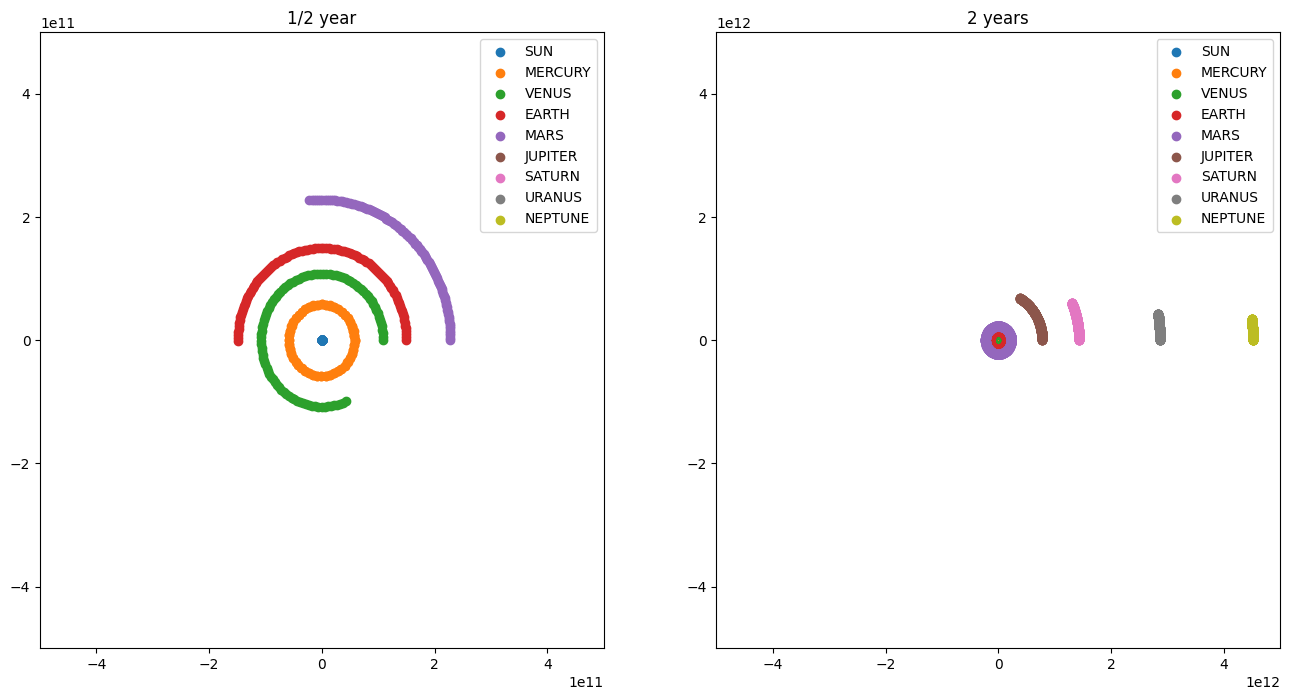

In [5]:
plt.figure(figsize=(16,8))

year = 31_536_000

t1 =  np.linspace(0, 1/2 * year, 100)
result1 = solve_ivp(n_body_system, (0, 1/2 * year), y0, t_eval=t1, method='Radau')
solution1 = result1.y.T

sb1 = plt.subplot(1,2,1)
scat_plots_1 = []
for i in range(0, solution1.shape[1], 4):
    scat_plots_1.append(sb1.scatter(solution1[:, i], solution1[:, i+1], label=names[i//4]))
sb1.set_title('1/2 year')

ax = plt.gca()
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])

t2 =  np.linspace(0, 2 * year, 365)
result2 = solve_ivp(n_body_system, (0, 12 * year), y0, t_eval=t2, method='Radau')
solution2 = result2.y.T

sb2 = plt.subplot(1,2,2)
scat_plots_2 = []
for i in range(0, solution2.shape[1], 4):
    scat_plots_2.append(sb2.scatter(solution2[:, i], solution2[:, i+1], label=names[i//4]))
sb2.set_title('2 years')
ax = plt.gca()
ax.set_xlim([-5e+12, 5e+12])
ax.set_ylim([-5e+12, 5e+12])

sb1.legend()
sb2.legend()
plt.show()

In [ ]:
camera = Camera(plt.figure())

colors = colormaps.get_cmap('Set1')(np.linspace(0, 1, 9))
for t in range(365):
    for i in range(0, solution1.shape[1], 4):
        plt.scatter(solution2[t, i], solution2[t, i+1], color = colors[i // 4], label=names[i//4])
    camera.snap()
ax = plt.gca()
ax.legend(names)  
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])
anim = camera.animate(blit=True)
writergif = animation.PillowWriter(fps=30)
anim.save('planets_scipy_2_years.gif',writer=writergif)

### П.2. Метод Верле

In [4]:
def a(y):
    '''
    a[0] ~ a_x
    a[1] ~ a_y
    '''
    a = np.zeros((y.shape[0]//4, 2), dtype=np.float64)
    
    for i in range(0, y.shape[0], 4): 
        for j in range(0, y.shape[0], 4): 
            if (i == j): continue
            x_length = y[j] - y[i]
            y_length = y[j+1] - y[i+1]
            r2 = x_length**2 + y_length**2
            r = np.sqrt(r2)
            f = G * m[j // 4] / r2
            a[i//4, 0] += f * x_length / r
            a[i//4, 1] += f * y_length / r
    return a


def verlet(t, y0):
    '''
    y[i] ~ x[i]
    y[i+1] ~ y[i]
    y[i+2] ~ v_x[i]
    y[i+3] ~ v_y[i]
    '''
    
    dt = t.astype(np.float64)[1]
    
    solution = np.empty((t.shape[0], y0.shape[0]), dtype=np.float64)
    
    solution[0, :] = y0
    a_n = a(solution[0, :])
    
    for i in range(1, solution.shape[0]):
        solution[i, 0:4] = solution[i-1, 0:4]
        
        for j in range(4, solution.shape[1], 4): 
            index = j//4
            solution[i, j] = solution[i-1, j] + solution[i-1, j+2] * dt + 0.5 * a_n[index, 0] * dt**2
            solution[i, j+1] = solution[i-1, j+1] + solution[i-1, j+3] * dt + 0.5 * a_n[index, 1] * dt**2
        
        a_n1 = a(solution[i, :])
        
        for j in range(4, solution.shape[1], 4): 
            index = j//4
            solution[i, j+2] = solution[i-1, j+2] + 0.5 * (a_n1[index, 0] + a_n[index, 0]) * dt
            solution[i, j+3] = solution[i-1, j+3] + 0.5 * (a_n1[index, 1] + a_n[index, 1]) * dt
        
        a_n = a_n1
    
    return solution

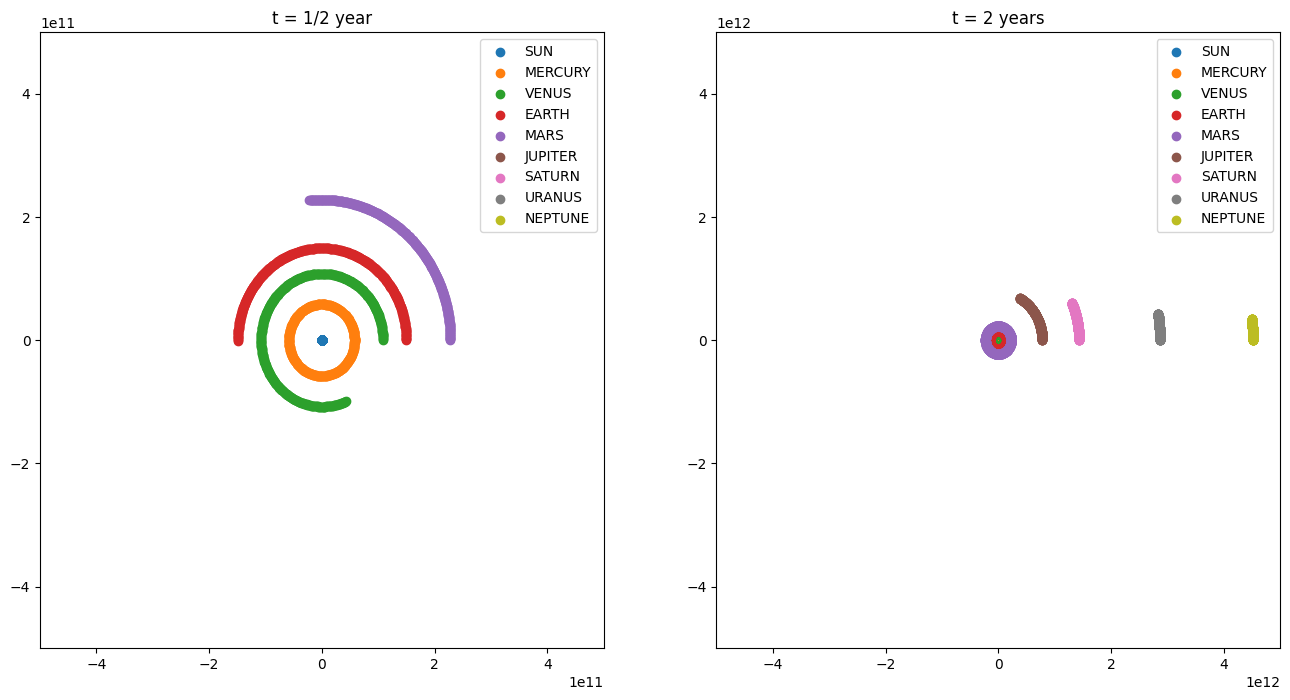

In [ ]:
plt.figure(figsize=(16,8))

year = 31_536_000

t1 =  np.linspace(0, 1/2 * year, 365)
solution1 = verlet(t1, y0)

sb1 = plt.subplot(1,2,1)
scat_plots_1 = []
for i in range(0, solution1.shape[1], 4):
    scat_plots_1.append(sb1.scatter(solution1[:, i], solution1[:, i+1], label=names[i//4]))
sb1.set_title('t = 1/2 year')

ax = plt.gca()
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])

t2 =  np.linspace(0, 2 * year, 365)
solution2 = verlet(t2, y0)
    
sb2 = plt.subplot(1,2,2)
scat_plots_2 = []
for i in range(0, solution2.shape[1], 4):
    scat_plots_2.append(sb2.scatter(solution2[:, i], solution2[:, i+1], label=names[i//4]))
sb2.set_title('t = 2 years')
ax = plt.gca()
ax.set_xlim([-5e+12, 5e+12])
ax.set_ylim([-5e+12, 5e+12])

sb1.legend()
sb2.legend()
plt.show()

### П.3. Метод Верле и multiprocessing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mp_solution import *



G = 6.6743e-11
m = [1.989e+30, 0.330e+24,	4.87e+24,	5.97e+24,	0.642e+24,	1898e+24,	568e+24,	86.8e+24,	102e+24]
names = ['SUN',  'MERCURY', 	 'VENUS', 	 'EARTH', 	'MARS', 	 'JUPITER', 	 'SATURN', 	 'URANUS', 	 'NEPTUNE']
y0 = np.array([0,    0,  0, 0,
      57.9e+9, 0,	0, 48000,
      108.2e+9, 0, 0, 35000,	
      149.6e+9,	0, 0, 29765, 
      228.0e+9, 0, 0, 24130,	
      778.5e+9, 0, 0, 13070,	
      1432.0e+9, 0, 0, 9870,	
      2867.0e+9, 0, 0, 6810,	
      4515.0e+9, 0, 0, 5434]) 

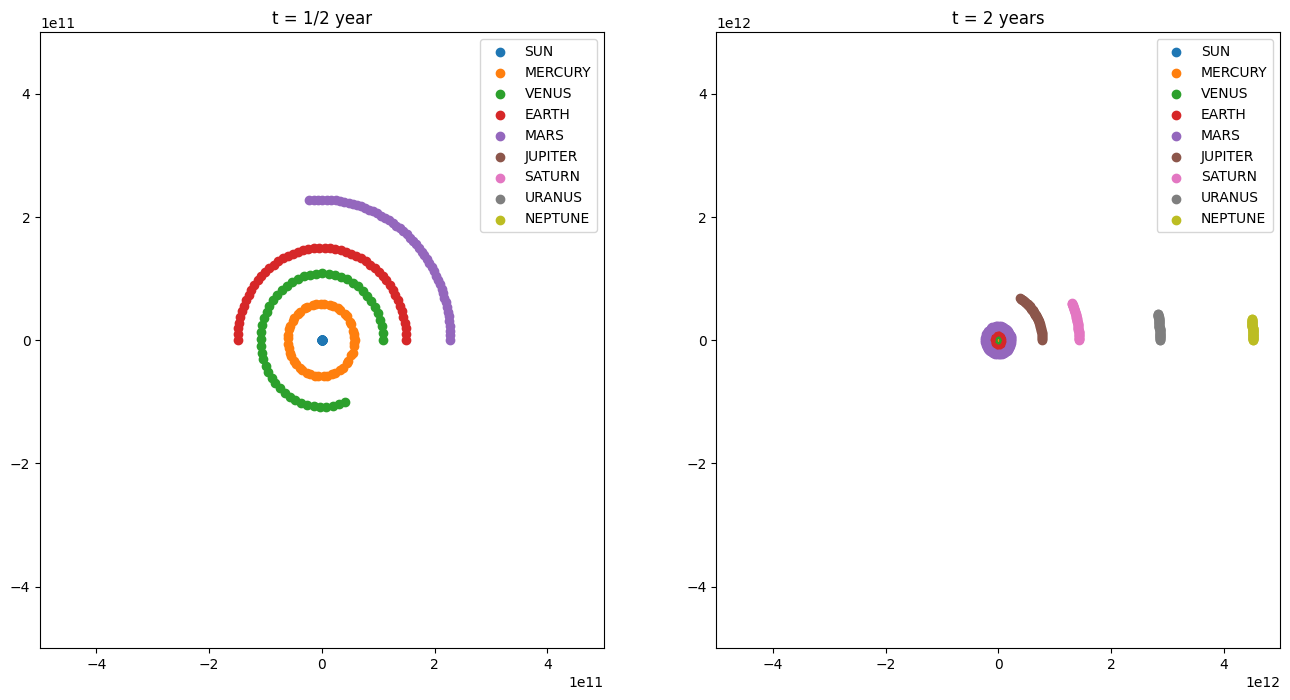

In [ ]:
plt.figure(figsize=(16,8))

year = 31_536_000

t1 =  np.linspace(0, 1/2 * year, 50)
solution1 = verlet_mp(t1, y0, m)

sb1 = plt.subplot(1,2,1)
scat_plots_1 = []
for i in range(0, solution1.shape[1], 4):
    scat_plots_1.append(sb1.scatter(solution1[:, i], solution1[:, i+1], label=names[i//4]))
sb1.set_title('t = 1/2 year')

ax = plt.gca()
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])

t2 =  np.linspace(0, 2 * year, 50)
solution2 = verlet_mp(t2, y0, m)
    
sb2 = plt.subplot(1,2,2)
scat_plots_2 = []
for i in range(0, solution2.shape[1], 4):
    scat_plots_2.append(sb2.scatter(solution2[:, i], solution2[:, i+1], label=names[i//4]))
sb2.set_title('t = 2 years')
ax = plt.gca()
ax.set_xlim([-5e+12, 5e+12])
ax.set_ylim([-5e+12, 5e+12])

sb1.legend()
sb2.legend()
plt.show()

### Сравнение погрешностей

In [ ]:
year = 31_536_000

t1 =  np.linspace(0, 1 * year, 50)

solution_scipy = solve_ivp(n_body_system, (0, 1 * year), y0, t_eval=t1, method='Radau').y.T
solution_verlet = verlet(t1, y0)
solution_mp = verlet_mp(t1, y0, m)

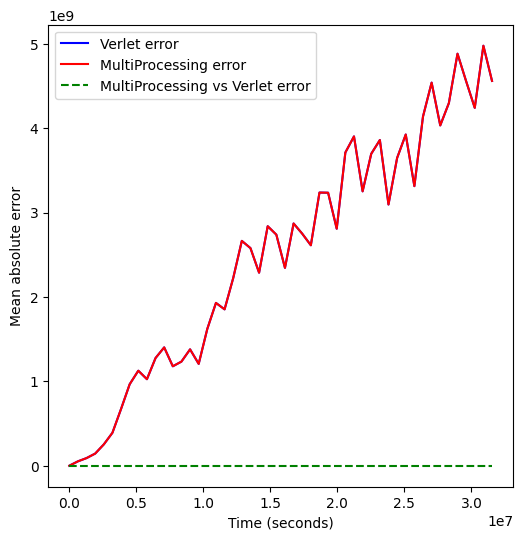

In [ ]:
plt.figure(figsize=(6,6))

verlet_error = np.mean(np.abs(solution_scipy - solution_verlet), axis=1)
mp_error = np.mean(np.abs(solution_scipy - solution_mp), axis=1)


mp_verlet_error = np.mean(np.abs(solution_verlet - solution_mp), axis=1)

plt.plot(t1, verlet_error, 'b', label='Verlet error')
plt.plot(t1, mp_error, 'r', label='MultiProcessing error')
plt.plot(t1, mp_verlet_error, 'g--', label='MultiProcessing vs Verlet error')

ax = plt.gca()
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Time (seconds)')
plt.legend()
plt.show()

### Сравнение времени работы

In [14]:
from time import time

N = [200, 400, 800, 1000]
t1 =  np.linspace(0, 100, 10)
times = []


In [15]:
for n in N:
    print("n = ", n)
    # Создаем случайные начальные условия и массы
    y = np.random.rand(4 * n)
    m = np.random.rand(n)
    time_v = []
    time_mp = []
    for i in range (3):
        # Verlet time
        start_v = time()
        result = verlet(t1, y)
        time_v.append(time() - start_v)
        # Verlet multiprocessing time
        start_mp = time()
        result = verlet_mp(t1, y, m)
        time_mp.append(time() - start_mp)
    print('verlet = ', np.mean(time_v))
    print('verlet_mp = ', np.mean(time_mp))
    times.append(np.array([np.mean(time_v), np.mean(time_mp)]))

n =  200
verlet =  1.4142327308654785
verlet_mp =  4.538324515024821
n =  400
verlet =  3.2783048152923584
verlet_mp =  5.170005400975545
n =  800
verlet =  12.634917656580607
verlet_mp =  8.1218581199646
n =  1000
verlet =  20.547168254852295
verlet_mp =  10.358659903208414


In [20]:
np.array(times)[0]

array([1.41423273, 4.53832452])

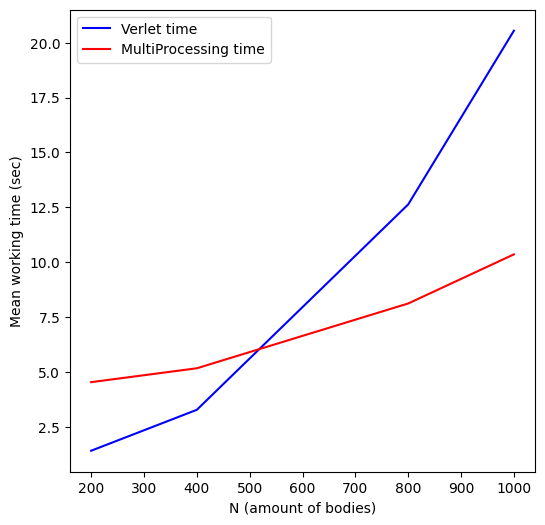

In [22]:
plt.figure(figsize=(6,6))
times = np.array(times)
plt.plot(N, times[:, 0], 'b', label='Verlet time')
plt.plot(N, times[:, 1], 'r', label='MultiProcessing time')

ax = plt.gca()
ax.set_ylabel('Mean working time (sec)')
ax.set_xlabel('N (amount of bodies)')
plt.legend()
plt.show()